# Error Analysis for Tabular Data.

In [1]:
# Platfrom information
%load_ext watermark
%watermark

2021-11-07T14:13:58+01:00

CPython 3.6.2
IPython 7.16.1

compiler   : GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)
system     : Darwin
release    : 19.6.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit


In [2]:
#Import all libraries
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.metrics import roc_auc_score
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from raiwidgets import ErrorAnalysisDashboard
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
from src.model import select_features
from src.model import tune_parameters,show_model_results
%matplotlib inline

In [3]:
#Package versions installed
%watermark --iversions

pandas     1.0.3
numpy      1.19.5
matplotlib 3.2.1



### Read & Clean Data

In [4]:
#Read dataset.
data = pd.read_csv('../data/heloc_dataset_v1.csv')
# Data Cleaning based on Error analysis.
data = data[data['NumSatisfactoryTrades']>=0]
data = data[data['ExternalRiskEstimate']>=0]

In [5]:
# Split data into Train & Test Set.
y = data['RiskPerformance'].apply(lambda x : 1 if 'Bad' in x else 0)
print(f"Class balance :\n{y.value_counts(normalize=True)}")
X = data.drop(columns='RiskPerformance')
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=345,stratify=y)
data_dict = {'xtrain': X_train, 'ytrain': y_train,'xtest' : X_test, 'ytest' : y_test}

Class balance :
1    0.520028
0    0.479972
Name: RiskPerformance, dtype: float64


### Feature Selection

Selected features : ['NumSatisfactoryTrades', 'MSinceMostRecentInqexcl7days', 'NetFractionRevolvingBurden', 'AverageMInFile', 'ExternalRiskEstimate'] 


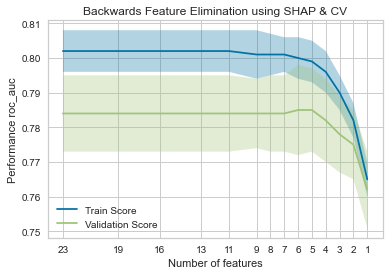

In [6]:
selected_features,fs_plot = select_features(data=data_dict,n_features=5)

We can see that 5 features are most important, we will go ahead with only these ones.

This also makes life easy to do error analysis.

In [34]:
# Subset the dataset with the selected features.

data_dict['xtrain'] = data_dict['xtrain'][selected_features]
data_dict['xtest'] = data_dict['xtest'][selected_features]
print(f'Using features :{[x for x in selected_features]}')

Using features :['NumSatisfactoryTrades', 'MSinceMostRecentInqexcl7days', 'NetFractionRevolvingBurden', 'AverageMInFile', 'ExternalRiskEstimate']


### Train Model

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Creating model with features : {'subsample': 0.7, 'min_child_weight': 3, 'max_depth': 7, 'lambda': 1.0, 'gamma': 0.05, 'eta': 0.025, 'colsample_bytree': 0.7, 'alpha': 0.1, 'monotone_constraints': (-1, -1, -1, 1, -1)}
Train ROC-AUC score : 0.7947988441389943
Test ROC-AUC score : 0.8009147150609962
Test Accuracy socre : 0.7347076715106455


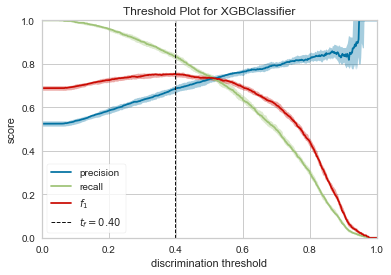

In [8]:
model = XGBClassifier()
model_param = tune_parameters(data=data_dict,model=model)
# Add monotonic constraints.
model_param['monotone_constraints']=(-1,-1,-1,+1,-1)
print(f"Creating model with features : {model_param}")
clf = XGBClassifier(**model_param)
model = show_model_results(data=data_dict,model=clf)

### Feature Importances & Model Interpretability

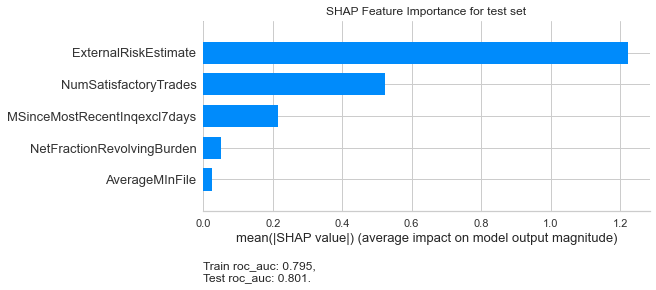

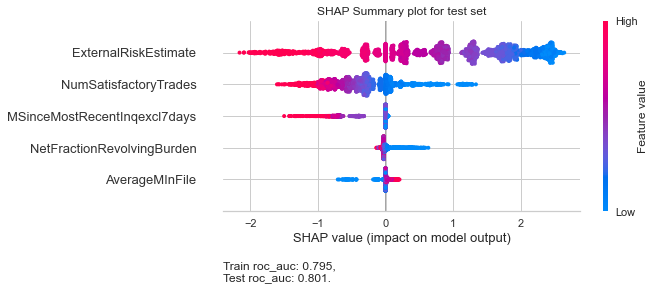

In [9]:
from probatus.interpret import ShapModelInterpreter
shap_interpreter = ShapModelInterpreter(model)
feature_importance = shap_interpreter.fit_compute(
    data_dict['xtrain'][selected_features], 
    data_dict['xtest'][selected_features], 
    data_dict['ytrain'],
     data_dict['ytest'], approximate=False)
shap_interpreter.plot('importance');
ax2 = shap_interpreter.plot('summary')

So it is `decent` model, now lets start to use the various error analysis method and see if we can do something and
improve the model. 

## Residual Analysis

The error analysis library by Microsoft, deals with preddictions.

Thus we will convert the probabilities to predictions, using the above output.
0.57 seems to be a good threshold.

In [19]:
yhat_name = 'p_RiskPerformance'
y_name = 'RiskPerformance' 
resid_name = 'r_RiskPerformance' 
probas = model.predict_proba(data_dict['xtest'])[:,1]
data_dict['xtest'][yhat_name] = probas
data_dict['xtest'][y_name] = data_dict['ytest']



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [20]:
# calculate logloss residuals
data_dict['xtest'][resid_name] = -data_dict['xtest'][y_name]*np.log(data_dict['xtest'][yhat_name]) -\
                       (1 - data_dict['xtest'][y_name])*np.log(1 - data_dict['xtest'][yhat_name])   
# Check that logloss is calculated correctly
print('Mean logloss residual: %.6f' % data_dict['xtest'][resid_name].mean())

Mean logloss residual: 0.544942


### Plot residuals

Plotting residuals is a model debugging and diagnostic tool that enables users to see modeling results, and any anomolies, in a single two-dimensional plot. Here the pink points represent customers who defaulted, and the blue points represent customers who did not. A few potential outliers are visible. There appear to be several cases in the validation data with relatively large residuals. Understanding and addressing the factors that cause these outliers could lead to a more acccurate model.

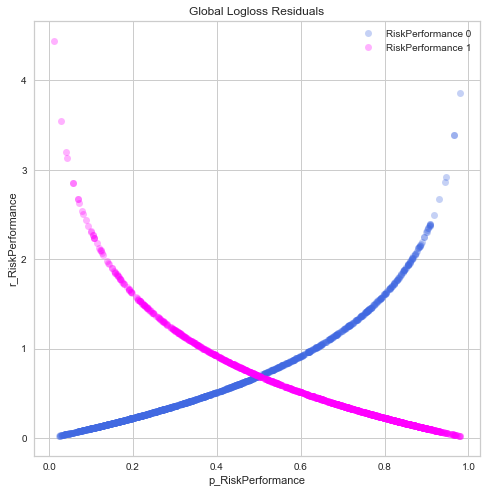

In [21]:
 # initialize figure
fig, ax_ = plt.subplots(figsize=(8, 8))         

# plot groups with appropriate color
color_list = ['royalblue', 'magenta'] 
c_idx = 0
groups = data_dict['xtest'].groupby(y_name) # define groups for levels of PAY_0
for name, group in groups:
    ax_.plot(group.p_RiskPerformance, group.r_RiskPerformance, 
             label=' '.join([y_name, str(name)]),
             marker='o', linestyle='', color=color_list[c_idx], alpha=0.3)
    c_idx += 1
    
# annotate plot
plt.xlabel(yhat_name)
plt.ylabel(resid_name)
ax_.legend(loc=1)
plt.title('Global Logloss Residuals')
plt.show()

### DEFAULT_NEXT_MONTH = 1 residuals


In [13]:
valid_yhat_df1 = data_dict['xtest'][data_dict['xtest'][y_name] == 1]
valid_yhat_df1 = valid_yhat_df1.sort_values(by='r_RiskPerformance', ascending=False)
valid_yhat_df1.head(10)

,NumSatisfactoryTrades,MSinceMostRecentInqexcl7days,NetFractionRevolvingBurden,AverageMInFile,ExternalRiskEstimate,p_RiskPerformance,RiskPerformance,r_RiskPerformance
8863,27,22,2,110,91,0.011731,1,4.445529
7775,45,14,1,78,87,0.028939,1,3.542577
5566,23,3,4,103,91,0.040970,1,3.194904
7717,19,9,10,96,89,0.043613,1,3.132403
6062,22,24,0,112,86,0.057504,1,2.855896
3909,43,2,8,59,84,0.057897,1,2.849093
331,42,0,9,63,87,0.068708,1,2.677886
5559,35,0,8,71,88,0.068773,1,2.676939
547,53,-7,5,67,86,0.072052,1,2.630363
9322,24,22,26,138,83,0.078962,1,2.538794


### DEFAULT_NEXT_MONTH = 0 residuals

In [14]:
valid_yhat_df0 = data_dict['xtest'][data_dict['xtest'][y_name] == 0]
valid_yhat_df0 = valid_yhat_df0.sort_values(by='r_RiskPerformance', ascending=False)
valid_yhat_df0.head()


,NumSatisfactoryTrades,MSinceMostRecentInqexcl7days,NetFractionRevolvingBurden,AverageMInFile,ExternalRiskEstimate,p_RiskPerformance,RiskPerformance,r_RiskPerformance
1576,0,0,-8,59,57,0.978971,0,3.861864
5849,2,0,97,47,55,0.966395,0,3.393067
2052,4,0,-8,102,57,0.966353,0,3.391842
4520,3,-7,94,111,61,0.945790,0,2.914882
8738,1,0,18,7,60,0.942869,0,2.862410


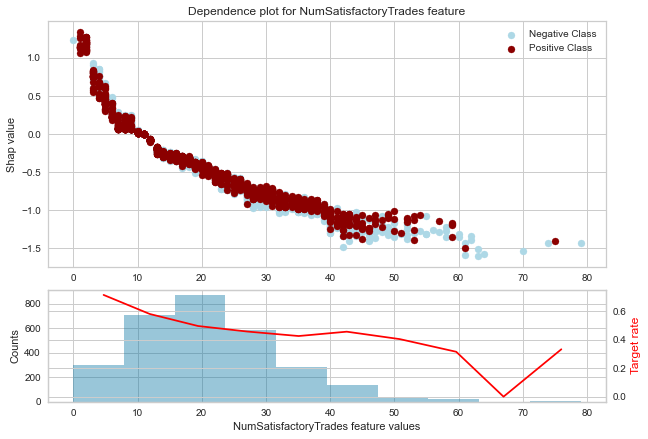

In [25]:
shap_interpreter.plot('dependence', target_columns=['NumSatisfactoryTrades']);

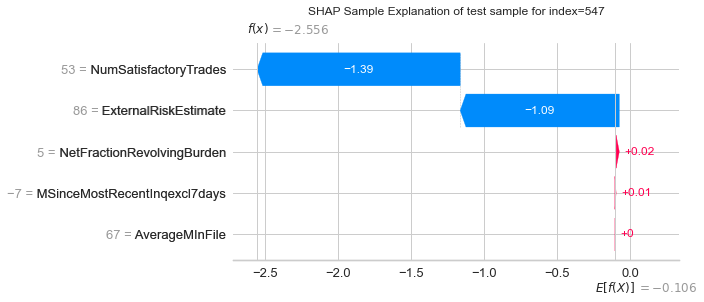

In [24]:
ax4 = shap_interpreter.plot('sample', samples_index=[547])

In [33]:
small_residual_df = data_dict['xtest'][data_dict['xtest']['r_RiskPerformance']>=3.0]
small_residual_df.describe().T

,count,mean,std,min,25%,50%,75%,max
NumSatisfactoryTrades,7.0,17.142857,16.364887,0.000000,3.000000,19.000000,25.000000,45.000000
MSinceMostRecentInqexcl7days,7.0,6.857143,8.571825,0.000000,0.000000,3.000000,11.500000,22.000000
NetFractionRevolvingBurden,7.0,14.000000,37.161808,-8.000000,-3.500000,2.000000,7.000000,97.000000
AverageMInFile,7.0,85.000000,24.248711,47.000000,68.500000,96.000000,102.500000,110.000000
ExternalRiskEstimate,7.0,75.285714,17.792454,55.000000,57.000000,87.000000,90.000000,91.000000
p_RiskPerformance,7.0,0.433853,0.502178,0.011731,0.034955,0.043613,0.966374,0.978971
RiskPerformance,7.0,0.571429,0.534522,0.000000,0.000000,1.000000,1.000000,1.000000
r_RiskPerformance,7.0,3.566027,0.455999,3.132403,3.293373,3.393067,3.702220,4.445529
